# HypergraphKHopLifting Tutorial

***
This notebook shows how to import a dataset, with the desired lifting, and how to run a neural network using the loaded data.

The notebook is divided into sections:

- [Loading the dataset](#loading-the-dataset) loads the config files for the data and the desired tranformation, createsa a dataset object and visualizes it.
- [Create NN model](#create-nn-model) defines a simple neural network to test that the lifting creates the expected incidence matrices.
- [Run](#run) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph, however there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
***

### Imports and utilities

In [1]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2

In [2]:
import pprint
import rootutils
import json

rootutils.setup_root("./", indicator=".project-root", pythonpath=True)
root_folder = rootutils.find_root()
import omegaconf
import torch
from modules.io.load.loaders import GraphLoader

## Loading the dataset

The dataset for this notebook is a manually created dataset with a single graph.

The configs to create the dataset are saved in a yaml file that is loaded using `omegaconf`.

Similarly the parameters for the tranformation to apply to the data are saved in another yaml file.

### Dataset config

In [3]:
dataset_name = "manual_dataset"

dataset_config = omegaconf.OmegaConf.load(
    f"{root_folder}/configs/dataset/{dataset_name}.yaml"
).parameters

# Print config file for nice visualization
dict2print = dataset_config.copy()
pprint.pp(dict(dict2print))

{'data_domain': 'graph',
 'data_type': 'manual_dataset',
 'data_name': 'manual',
 'data_dir': '/challenge-icml-2024/datasets/graph/manual_dataset',
 'num_features': 1,
 'num_classes': 2,
 'task': 'classification',
 'loss_type': 'cross_entropy',
 'monitor_metric': 'accuracy',
 'task_level': 'node',
 'split_type': 'k-fold',
 'k': 10,
 'data_seed': 0}


### Transform config

The *tranform_config* dictionary can contain a sequence of tranforms if it is needed.

In [4]:
# Define lifting type
lifting_type = "graph2hypergraph"

# Define lifting id (name)
id_lifting = "khop_lifting"

# Read yaml file
transform_config = {
    "lifting": omegaconf.OmegaConf.load(
        f"{root_folder}/configs/transforms/liftings/{lifting_type}/{id_lifting}.yaml"
    )
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}

# Print config file for nice visualization
dict2print = transform_config.copy()
dict2print["lifting"] = dict(dict2print["lifting"])

pprint.pp(dict(dict2print))

{'lifting': {'_target_': 'modules.transforms.data_transform.DataTransform',
             'transform_type': 'lifting',
             'transform_name': 'HypergraphKHopLifting',
             'k_value': 1,
             'feature_lifting': 'SumLifting'}}


### Load Dataset

In [5]:
dataset = GraphLoader(dataset_config, transform_config).load()

Transform parameters are the same, using existing data_dir: /challenge-icml-2024/datasets/graph/manual_dataset/manual/lifting/3568131876


/usr/local/lib/python3.11/site-packages/torch_geometric/data/in_memory_dataset.py:301: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Visualize graph

To visualize the obtained hypergraph we opted to draw a bipartite graph where the top nodes represent the hyperedges and the bottom nodes the nodes of the graph. If a node is connected to an hyperedge it means it belongs to that hyperedge.

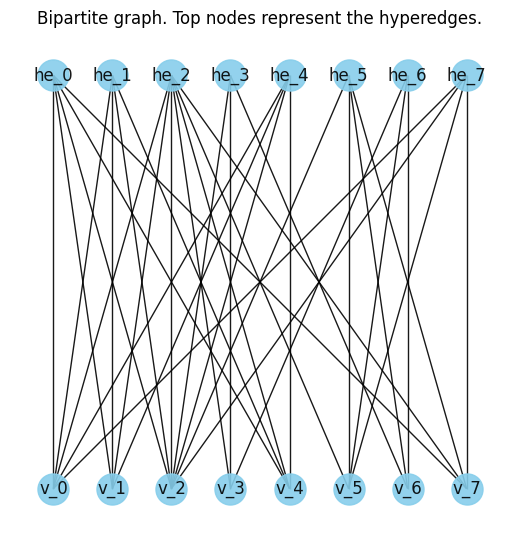

In [6]:
from modules.io.utils.utils import plot_manual_graph
plot_manual_graph(dataset)

In [7]:
incidence = dataset.incidence_hyperedges.coalesce()
indices = incidence.indices()

for he_idx in torch.unique(indices[1]):
    corresponding_idxs = indices[1]==he_idx
    nodes = indices[0,corresponding_idxs]
    print(f"Hyperedge {he_idx} is composed from the edges {nodes.numpy()}")

Hyperedge 0 is composed from the edges [0 1 2 4 7]
Hyperedge 1 is composed from the edges [0 1 2 4]
Hyperedge 2 is composed from the edges [0 1 2 3 4 5 7]
Hyperedge 3 is composed from the edges [2 3 6]
Hyperedge 4 is composed from the edges [0 1 2 4]
Hyperedge 5 is composed from the edges [2 5 6 7]
Hyperedge 6 is composed from the edges [3 5 6]
Hyperedge 7 is composed from the edges [0 2 5 7]


## Create NN Model

In [8]:
from topomodelx.nn.hypergraph.unigcn import UniGCN
import torch


class Network(torch.nn.Module):
    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
    ):
        super().__init__()
        self.base_model = UniGCN(
            in_channels,
            hidden_channels,
        )
        self.linear_0 = torch.nn.Linear(hidden_channels, out_channels)
        self.linear_1 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x_0, x_1 = self.base_model(
            data.x_0,
            data.incidence_hyperedges,
        )
        x_0 = self.linear_0(x_0)
        x_1 = self.linear_1(x_1)
        return x_0, x_1

In [9]:
in_channels = dataset_config["num_features"]
hidden_channels = 32
out_channels = dataset_config["num_classes"]

model = Network(
    in_channels=in_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
)

## Run

In [10]:
y_hat = model(dataset)